In [13]:
#Model
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import datetime
import cv2
from keras import backend as K
from keras.layers import Layer,InputSpec
from keras import layers
import keras.layers as kl
from glob import glob
from sklearn.metrics import roc_curve, auc
from keras.preprocessing import image
from tensorflow.keras.models import Sequential
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from tensorflow.keras import callbacks 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from  matplotlib import pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.layers import concatenate, Dense, Conv2D, MaxPooling2D, Flatten, Input, Activation, add, AveragePooling2D, BatchNormalization, Dropout
%matplotlib inline
import shutil
from sklearn.metrics import  precision_score, recall_score, accuracy_score,classification_report ,confusion_matrix
from tensorflow.python.platform import build_info as tf_build_info
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


#Server Deployment
from flask import Flask, send_file, request, jsonify, make_response, current_app
from flask_ngrok import run_with_ngrok
from flask_cors import CORS
from functools import update_wrapper, wraps
from pyngrok import ngrok
import requests

#Diagnosis
from ipywidgets import Button
from tkinter import Tk, filedialog
from IPython.display import clear_output, display
from beautifultable import BeautifulTable
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
# Environment variable
main_dir = 'D:/Data/HAM100000 - Harvard Dataset'
main_img_dir = main_dir + '/img_data'
preprocessed_data_dir = main_dir + '/preprocessed_data'
train_dir = preprocessed_data_dir + '/train'
test_dir = preprocessed_data_dir + '/val'
train_label = preprocessed_data_dir + '/train_label.csv'
val_label = preprocessed_data_dir + '/val_label.csv'

aug_label = preprocessed_data_dir + '/aug_label.csv'
aug_img_data_dir = main_dir + '/augmented_data'

# ModelPath
main_git_dir = 'D:/GithubCloneRepo/Skin-Disease-Detection-and-Segmentation-HAM100000'
experiment_dir = main_git_dir + '/Experiment'
aug_model_dir = experiment_dir + "/Model With Soft Attention and Augmentation"
non_aug_model_dir = experiment_dir + "/Model With Soft Attention, Metadata, and Weigth Loss"

IRV2_SA = aug_model_dir + "/IRV2+SA.hdf5"
ResNet50_SA = aug_model_dir + "/ResNet50+SA.hdf5"
ResNet152_SA = aug_model_dir + "/ResNet152+SA.hdf5"
DEN201_SA = aug_model_dir + "/DEN201+SA.hdf5"
VGG16_SA = aug_model_dir + "/vgg16+SA.hdf5"

DEN201 = non_aug_model_dir + "/DenseNet201 - SoftAtt/densenetSoftAtt_10split_LRStr.hdf5"
IRV2 = non_aug_model_dir + "/IRV2 - SoftAtt/"
MobileNetV2 = non_aug_model_dir + "/MobileNetV2/"
MobileNetV3 = non_aug_model_dir + "/MobileNetV3/mobilenetv3LargeSoftAtt_10split_LRStr"
NasnetLarge = non_aug_model_dir + "/NasnetLarge - SoftAtt/"
NasNetMobile = non_aug_model_dir + "NasNetMobile/"
Resnet50 = non_aug_model_dir + "/Resnet50 - SoftAtt/"
Resnet152 = non_aug_model_dir + "Resnet152 - SoftAtt/"

In [2]:
irv2_fpr = """0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.67336011e-04 1.67336011e-04 1.67336011e-04 1.67336011e-04
 3.34672021e-04 3.34672021e-04 3.34672021e-04 3.34672021e-04
 3.34672021e-04 5.02008032e-04 5.02008032e-04 5.02008032e-04
 5.02008032e-04 6.69344043e-04 6.69344043e-04 6.69344043e-04
 8.36680054e-04 8.36680054e-04 1.00401606e-03 1.00401606e-03
 1.17135207e-03 1.17135207e-03 1.33868809e-03 1.33868809e-03
 1.50602410e-03 1.50602410e-03 1.67336011e-03 1.67336011e-03
 1.84069612e-03 1.84069612e-03 2.00803213e-03 2.00803213e-03
 2.17536814e-03 2.17536814e-03 2.34270415e-03 2.34270415e-03
 2.67737617e-03 2.67737617e-03 2.84471218e-03 2.84471218e-03
 3.01204819e-03 3.01204819e-03 3.17938420e-03 3.17938420e-03
 3.34672021e-03 3.34672021e-03 3.51405622e-03 3.51405622e-03
 3.68139224e-03 3.68139224e-03 3.84872825e-03 3.84872825e-03
 4.18340027e-03 4.18340027e-03 4.35073628e-03 4.35073628e-03
 4.51807229e-03 4.51807229e-03 4.68540830e-03 4.68540830e-03
 4.85274431e-03 4.85274431e-03 5.02008032e-03 5.02008032e-03
 5.18741633e-03 5.18741633e-03 5.35475234e-03 5.35475234e-03
 5.52208835e-03 5.52208835e-03 5.68942436e-03 5.68942436e-03
 5.85676037e-03 5.85676037e-03 6.02409639e-03 6.02409639e-03
 6.19143240e-03 6.19143240e-03 6.52610442e-03 6.52610442e-03
 6.69344043e-03 6.69344043e-03 6.86077644e-03 6.86077644e-03
 7.02811245e-03 7.02811245e-03 7.19544846e-03 7.19544846e-03
 7.36278447e-03 7.36278447e-03 7.53012048e-03 7.53012048e-03
 7.69745649e-03 7.69745649e-03 7.86479250e-03 7.86479250e-03
 8.03212851e-03 8.03212851e-03 8.19946452e-03 8.19946452e-03
 8.36680054e-03 8.36680054e-03 8.53413655e-03 8.53413655e-03
 8.70147256e-03 8.70147256e-03 8.86880857e-03 8.86880857e-03
 9.03614458e-03 9.03614458e-03 9.37081660e-03 9.37081660e-03
 9.53815261e-03 9.53815261e-03 1.00401606e-02 1.00401606e-02
 1.02074967e-02 1.02074967e-02 1.07095047e-02 1.07095047e-02
 1.12115127e-02 1.12115127e-02 1.13788487e-02 1.13788487e-02
 1.17135207e-02 1.17135207e-02 1.25502008e-02 1.25502008e-02
 1.28848728e-02 1.28848728e-02 1.32195448e-02 1.32195448e-02
 1.33868809e-02 1.33868809e-02 1.37215529e-02 1.37215529e-02
 1.38888889e-02 1.38888889e-02 1.40562249e-02 1.40562249e-02
 1.43908969e-02 1.43908969e-02 1.45582329e-02 1.45582329e-02
 1.48929050e-02 1.48929050e-02 1.53949130e-02 1.53949130e-02
 1.55622490e-02 1.55622490e-02 1.57295850e-02 1.57295850e-02
 1.60642570e-02 1.60642570e-02 1.72356091e-02 1.72356091e-02
 1.74029451e-02 1.74029451e-02 1.75702811e-02 1.75702811e-02
 1.82396252e-02 1.82396252e-02 1.84069612e-02 1.84069612e-02
 1.87416332e-02 1.87416332e-02 1.90763052e-02 1.90763052e-02
 1.92436412e-02 1.92436412e-02 1.95783133e-02 1.95783133e-02
 1.97456493e-02 1.97456493e-02 1.99129853e-02 1.99129853e-02
 2.05823293e-02 2.05823293e-02 2.09170013e-02 2.09170013e-02
 2.12516734e-02 2.12516734e-02 2.14190094e-02 2.14190094e-02
 2.19210174e-02 2.19210174e-02 2.22556894e-02 2.22556894e-02
 2.27576975e-02 2.27576975e-02 2.40963855e-02 2.40963855e-02
 2.45983936e-02 2.45983936e-02 2.49330656e-02 2.49330656e-02
 2.62717537e-02 2.62717537e-02 2.64390897e-02 2.64390897e-02
 2.66064257e-02 2.66064257e-02 2.67737617e-02 2.67737617e-02
 2.76104418e-02 2.76104418e-02 2.81124498e-02 2.81124498e-02
 2.82797858e-02 2.82797858e-02 2.84471218e-02 2.84471218e-02
 2.89491299e-02 2.89491299e-02 2.96184739e-02 2.96184739e-02
 3.16265060e-02 3.16265060e-02 3.21285141e-02 3.21285141e-02
 3.24631861e-02 3.24631861e-02 3.26305221e-02 3.26305221e-02
 3.29651941e-02 3.29651941e-02 3.39692102e-02 3.39692102e-02
 3.44712182e-02 3.44712182e-02 3.51405622e-02 3.51405622e-02
 3.53078983e-02 3.53078983e-02 3.56425703e-02 3.56425703e-02
 3.74832664e-02 3.74832664e-02 3.98259705e-02 3.98259705e-02
 4.11646586e-02 4.11646586e-02 4.14993307e-02 4.14993307e-02
 4.48460509e-02 4.48460509e-02 4.51807229e-02 4.51807229e-02
 4.53480589e-02 4.53480589e-02 4.70214190e-02 4.70214190e-02
 4.81927711e-02 4.81927711e-02 4.83601071e-02 4.83601071e-02
 4.98661312e-02 4.98661312e-02 5.12048193e-02 5.12048193e-02
 5.20414993e-02 5.20414993e-02 5.45515395e-02 5.45515395e-02
 5.48862115e-02 5.48862115e-02 5.94042838e-02 5.94042838e-02
 5.95716198e-02 5.95716198e-02 6.00736278e-02 6.00736278e-02
 6.02409639e-02 6.02409639e-02 6.17469880e-02 6.17469880e-02
 6.22489960e-02 6.22489960e-02 6.35876841e-02 6.35876841e-02
 6.37550201e-02 6.37550201e-02 6.82730924e-02 6.82730924e-02
 7.09504685e-02 7.09504685e-02 8.26639893e-02 8.26639893e-02
 8.28313253e-02 8.28313253e-02 8.43373494e-02 8.43373494e-02
 8.66800535e-02 8.66800535e-02 9.13654618e-02 9.13654618e-02
 9.45448461e-02 9.45448461e-02 1.00234270e-01 1.00234270e-01
 1.02911647e-01 1.02911647e-01 1.07429719e-01 1.07429719e-01
 1.07931727e-01 1.07931727e-01 1.11613119e-01 1.11613119e-01
 1.14792503e-01 1.14792503e-01 1.22155288e-01 1.22155288e-01
 1.24497992e-01 1.24497992e-01 1.29016064e-01 1.29016064e-01
 1.31526104e-01 1.31526104e-01 1.31860776e-01 1.31860776e-01
 1.37048193e-01 1.37048193e-01 1.58467202e-01 1.58467202e-01
 1.64825971e-01 1.64825971e-01 1.67001339e-01 1.67001339e-01
 1.83567604e-01 1.83567604e-01 1.84906292e-01 1.84906292e-01
 1.85742972e-01 1.85742972e-01 1.92436412e-01 1.92436412e-01
 1.93775100e-01 1.93775100e-01 2.08668005e-01 2.08668005e-01
 2.18373494e-01 2.18373494e-01 2.76271754e-01 2.76271754e-01
 3.02208835e-01 3.02208835e-01 3.14759036e-01 3.14759036e-01
 3.66967871e-01 3.66967871e-01 4.03781794e-01 4.03781794e-01
 1.00000000e+00"""

In [4]:
irv2_fpr = [float(x) for x in irv2_fpr.split()]
irv2_fpr

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.000167336011,
 0.000167336011,
 0.000167336011,
 0.000167336011,
 0.000334672021,
 0.000334672021,
 0.000334672021,
 0.000334672021,
 0.000334672021,
 0.000502008032,
 0.000502008032,
 0.000502008032,
 0.000502008032,
 0.000669344043,
 0.000669344043,
 0.000669344043,
 0.000836680054,
 0.000836680054,
 0.00100401606,
 0.00100401606,
 0.00117135207,
 0.00117135207,
 0.00133868809,
 0.00133868809,
 0.0015060241,
 0.0015060241,
 0.00167336011,
 0.00167336011,
 0.00184069612,
 0.00184069612,
 0.00200803213,
 0.00200803213,
 0.00217536814,
 0.00217536814,
 0.00234270415,
 0.00234270415,
 0.00267737617,
 0.00267737617,
 0.00284471218,
 0.00284471218,
 0.00301204819,
 0.00301204819,
 0.0031793842,
 0.003179

In [6]:
irv2_tpr = """0.         0.03313253 0.04317269 0.05923695 0.07128514 0.0753012
 0.07730924 0.08032129 0.08232932 0.08634538 0.08835341 0.09136546
 0.09236948 0.09437751 0.09738956 0.10341365 0.11345382 0.11546185
 0.11646586 0.12248996 0.12449799 0.12751004 0.12951807 0.1315261
 0.13353414 0.14056225 0.14257028 0.14457831 0.14759036 0.15261044
 0.15461847 0.15963855 0.16164659 0.18072289 0.18273092 0.18373494
 0.187751   0.1937751  0.19578313 0.19779116 0.1997992  0.20481928
 0.20682731 0.21184739 0.21586345 0.22891566 0.23192771 0.2439759
 0.2439759  0.24497992 0.24698795 0.24899598 0.25100402 0.25301205
 0.25702811 0.25903614 0.26506024 0.26506024 0.28514056 0.28714859
 0.3935743  0.3935743  0.437751   0.43975904 0.43975904 0.45983936
 0.45983936 0.50401606 0.50401606 0.51104418 0.51104418 0.51305221
 0.51305221 0.54116466 0.54116466 0.54718876 0.54718876 0.57028112
 0.57028112 0.57730924 0.57730924 0.58032129 0.58032129 0.58634538
 0.58634538 0.62148594 0.62148594 0.63253012 0.63253012 0.63453815
 0.63453815 0.64257028 0.64257028 0.65361446 0.65361446 0.66666667
 0.66666667 0.66967871 0.66967871 0.68473896 0.68473896 0.69678715
 0.69678715 0.71686747 0.71686747 0.7188755  0.7188755  0.72791165
 0.72791165 0.72991968 0.72991968 0.73192771 0.73192771 0.73393574
 0.73393574 0.73694779 0.73694779 0.73995984 0.73995984 0.74096386
 0.74096386 0.74698795 0.74698795 0.75100402 0.75100402 0.75903614
 0.75903614 0.76004016 0.76004016 0.76907631 0.76907631 0.77108434
 0.77108434 0.7751004  0.7751004  0.77610442 0.77610442 0.78212851
 0.78212851 0.78815261 0.78815261 0.79216867 0.79216867 0.79417671
 0.79417671 0.79618474 0.79618474 0.80321285 0.80321285 0.80923695
 0.80923695 0.81024096 0.81024096 0.81124498 0.81124498 0.81626506
 0.81626506 0.81726908 0.81726908 0.81827309 0.81827309 0.81927711
 0.81927711 0.82028112 0.82028112 0.82228916 0.82228916 0.83232932
 0.83232932 0.84036145 0.84036145 0.84136546 0.84136546 0.84337349
 0.84337349 0.84538153 0.84538153 0.84839357 0.84839357 0.85441767
 0.85441767 0.85843373 0.85843373 0.85943775 0.85943775 0.86144578
 0.86144578 0.86445783 0.86445783 0.8684739  0.8684739  0.86947791
 0.86947791 0.87048193 0.87048193 0.87148594 0.87148594 0.87349398
 0.87349398 0.87550201 0.87550201 0.87650602 0.87650602 0.87951807
 0.87951807 0.88253012 0.88253012 0.88353414 0.88353414 0.88554217
 0.88554217 0.88855422 0.88855422 0.88955823 0.88955823 0.89156627
 0.89156627 0.89257028 0.89257028 0.8935743  0.8935743  0.89558233
 0.89558233 0.89658635 0.89658635 0.89759036 0.89759036 0.90060241
 0.90060241 0.90361446 0.90361446 0.90662651 0.90662651 0.90863454
 0.90863454 0.90963855 0.90963855 0.91064257 0.91064257 0.91164659
 0.91164659 0.9126506  0.9126506  0.91365462 0.91365462 0.91465863
 0.91465863 0.91566265 0.91566265 0.91666667 0.91666667 0.91767068
 0.91767068 0.9186747  0.9186747  0.92168675 0.92168675 0.92269076
 0.92269076 0.9246988  0.9246988  0.92670683 0.92670683 0.92771084
 0.92771084 0.92871486 0.92871486 0.92971888 0.92971888 0.93072289
 0.93072289 0.93172691 0.93172691 0.93373494 0.93373494 0.93473896
 0.93473896 0.93674699 0.93674699 0.937751   0.937751   0.93875502
 0.93875502 0.93975904 0.93975904 0.94076305 0.94076305 0.94176707
 0.94176707 0.94277108 0.94277108 0.94477912 0.94477912 0.94578313
 0.94578313 0.94678715 0.94678715 0.94779116 0.94779116 0.94879518
 0.94879518 0.9497992  0.9497992  0.95080321 0.95080321 0.95281124
 0.95281124 0.95381526 0.95381526 0.95481928 0.95481928 0.95582329
 0.95582329 0.95682731 0.95682731 0.95783133 0.95783133 0.95883534
 0.95883534 0.95983936 0.95983936 0.96084337 0.96084337 0.96184739
 0.96184739 0.96285141 0.96285141 0.96385542 0.96385542 0.96485944
 0.96485944 0.96586345 0.96586345 0.96686747 0.96686747 0.96787149
 0.96787149 0.9688755  0.9688755  0.96987952 0.96987952 0.97088353
 0.97088353 0.97188755 0.97188755 0.97289157 0.97289157 0.97389558
 0.97389558 0.9748996  0.9748996  0.97590361 0.97590361 0.97690763
 0.97690763 0.97791165 0.97791165 0.97891566 0.97891566 0.97991968
 0.97991968 0.98092369 0.98092369 0.98192771 0.98192771 0.98293173
 0.98293173 0.98393574 0.98393574 0.98493976 0.98493976 0.98594378
 0.98594378 0.98694779 0.98694779 0.98795181 0.98795181 0.98895582
 0.98895582 0.98995984 0.98995984 0.99096386 0.99096386 0.99196787
 0.99196787 0.99297189 0.99297189 0.9939759  0.9939759  0.99497992
 0.99497992 0.99598394 0.99598394 0.99698795 0.99698795 0.99799197
 0.99799197 0.99899598 0.99899598 1.         1.        """

In [7]:
irv2_tpr = [float(x) for x in irv2_tpr.split()]
irv2_tpr

[0.0,
 0.03313253,
 0.04317269,
 0.05923695,
 0.07128514,
 0.0753012,
 0.07730924,
 0.08032129,
 0.08232932,
 0.08634538,
 0.08835341,
 0.09136546,
 0.09236948,
 0.09437751,
 0.09738956,
 0.10341365,
 0.11345382,
 0.11546185,
 0.11646586,
 0.12248996,
 0.12449799,
 0.12751004,
 0.12951807,
 0.1315261,
 0.13353414,
 0.14056225,
 0.14257028,
 0.14457831,
 0.14759036,
 0.15261044,
 0.15461847,
 0.15963855,
 0.16164659,
 0.18072289,
 0.18273092,
 0.18373494,
 0.187751,
 0.1937751,
 0.19578313,
 0.19779116,
 0.1997992,
 0.20481928,
 0.20682731,
 0.21184739,
 0.21586345,
 0.22891566,
 0.23192771,
 0.2439759,
 0.2439759,
 0.24497992,
 0.24698795,
 0.24899598,
 0.25100402,
 0.25301205,
 0.25702811,
 0.25903614,
 0.26506024,
 0.26506024,
 0.28514056,
 0.28714859,
 0.3935743,
 0.3935743,
 0.437751,
 0.43975904,
 0.43975904,
 0.45983936,
 0.45983936,
 0.50401606,
 0.50401606,
 0.51104418,
 0.51104418,
 0.51305221,
 0.51305221,
 0.54116466,
 0.54116466,
 0.54718876,
 0.54718876,
 0.57028112,
 0.57

In [9]:
den_fpr = """0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.67336011e-04 1.67336011e-04 1.67336011e-04
 1.67336011e-04 1.67336011e-04 1.67336011e-04 1.67336011e-04
 1.67336011e-04 1.67336011e-04 1.67336011e-04 1.67336011e-04
 1.67336011e-04 1.67336011e-04 1.67336011e-04 1.67336011e-04
 1.67336011e-04 1.67336011e-04 1.67336011e-04 1.67336011e-04
 1.67336011e-04 1.67336011e-04 1.67336011e-04 1.67336011e-04
 1.67336011e-04 1.67336011e-04 1.67336011e-04 1.67336011e-04
 1.67336011e-04 1.67336011e-04 1.67336011e-04 3.34672021e-04
 3.34672021e-04 5.02008032e-04 5.02008032e-04 5.02008032e-04
 5.02008032e-04 5.02008032e-04 5.02008032e-04 6.69344043e-04
 6.69344043e-04 8.36680054e-04 8.36680054e-04 1.00401606e-03
 1.00401606e-03 1.33868809e-03 1.33868809e-03 1.50602410e-03
 1.50602410e-03 1.67336011e-03 1.67336011e-03 1.84069612e-03
 1.84069612e-03 2.00803213e-03 2.00803213e-03 2.17536814e-03
 2.17536814e-03 2.51004016e-03 2.51004016e-03 2.67737617e-03
 2.67737617e-03 2.84471218e-03 2.84471218e-03 3.01204819e-03
 3.01204819e-03 3.17938420e-03 3.17938420e-03 3.34672021e-03
 3.34672021e-03 3.51405622e-03 3.51405622e-03 3.84872825e-03
 3.84872825e-03 4.01606426e-03 4.01606426e-03 4.35073628e-03
 4.35073628e-03 4.51807229e-03 4.51807229e-03 5.02008032e-03
 5.02008032e-03 5.18741633e-03 5.18741633e-03 5.35475234e-03
 5.35475234e-03 5.52208835e-03 5.52208835e-03 5.68942436e-03
 5.68942436e-03 5.85676037e-03 5.85676037e-03 6.02409639e-03
 6.02409639e-03 6.19143240e-03 6.19143240e-03 6.52610442e-03
 6.52610442e-03 6.86077644e-03 6.86077644e-03 7.02811245e-03
 7.02811245e-03 7.19544846e-03 7.19544846e-03 7.36278447e-03
 7.36278447e-03 7.53012048e-03 7.53012048e-03 7.69745649e-03
 7.69745649e-03 7.86479250e-03 7.86479250e-03 8.03212851e-03
 8.03212851e-03 8.36680054e-03 8.36680054e-03 8.53413655e-03
 8.53413655e-03 8.86880857e-03 8.86880857e-03 9.03614458e-03
 9.03614458e-03 9.20348059e-03 9.20348059e-03 9.37081660e-03
 9.37081660e-03 9.53815261e-03 9.53815261e-03 1.00401606e-02
 1.00401606e-02 1.02074967e-02 1.02074967e-02 1.03748327e-02
 1.03748327e-02 1.05421687e-02 1.05421687e-02 1.08768407e-02
 1.08768407e-02 1.13788487e-02 1.13788487e-02 1.17135207e-02
 1.17135207e-02 1.18808568e-02 1.18808568e-02 1.20481928e-02
 1.20481928e-02 1.25502008e-02 1.25502008e-02 1.30522088e-02
 1.30522088e-02 1.33868809e-02 1.33868809e-02 1.35542169e-02
 1.35542169e-02 1.40562249e-02 1.40562249e-02 1.43908969e-02
 1.43908969e-02 1.47255689e-02 1.47255689e-02 1.48929050e-02
 1.48929050e-02 1.50602410e-02 1.50602410e-02 1.53949130e-02
 1.53949130e-02 1.60642570e-02 1.60642570e-02 1.62315930e-02
 1.62315930e-02 1.65662651e-02 1.65662651e-02 1.70682731e-02
 1.70682731e-02 1.72356091e-02 1.72356091e-02 1.75702811e-02
 1.75702811e-02 1.79049531e-02 1.79049531e-02 1.80722892e-02
 1.80722892e-02 1.82396252e-02 1.82396252e-02 1.89089692e-02
 1.89089692e-02 1.90763052e-02 1.90763052e-02 1.94109772e-02
 1.94109772e-02 1.99129853e-02 1.99129853e-02 2.02476573e-02
 2.02476573e-02 2.15863454e-02 2.15863454e-02 2.27576975e-02
 2.27576975e-02 2.32597055e-02 2.32597055e-02 2.37617135e-02
 2.37617135e-02 2.40963855e-02 2.40963855e-02 2.42637216e-02
 2.42637216e-02 2.45983936e-02 2.45983936e-02 2.54350736e-02
 2.54350736e-02 2.57697456e-02 2.57697456e-02 2.59370817e-02
 2.59370817e-02 2.99531459e-02 2.99531459e-02 3.02878179e-02
 3.02878179e-02 3.07898260e-02 3.07898260e-02 3.12918340e-02
 3.12918340e-02 3.19611780e-02 3.19611780e-02 3.21285141e-02
 3.21285141e-02 3.22958501e-02 3.22958501e-02 3.27978581e-02
 3.27978581e-02 3.34672021e-02 3.34672021e-02 3.36345382e-02
 3.36345382e-02 3.41365462e-02 3.41365462e-02 3.46385542e-02
 3.46385542e-02 3.53078983e-02 3.53078983e-02 3.56425703e-02
 3.56425703e-02 3.61445783e-02 3.61445783e-02 3.78179384e-02
 3.78179384e-02 3.81526104e-02 3.81526104e-02 3.86546185e-02
 3.86546185e-02 3.89892905e-02 3.89892905e-02 3.93239625e-02
 3.93239625e-02 3.96586345e-02 3.96586345e-02 4.03279786e-02
 4.03279786e-02 4.13319946e-02 4.13319946e-02 4.28380187e-02
 4.28380187e-02 4.38420348e-02 4.38420348e-02 4.50133869e-02
 4.50133869e-02 4.61847390e-02 4.61847390e-02 4.65194110e-02
 4.65194110e-02 4.73560910e-02 4.73560910e-02 4.95314592e-02
 4.95314592e-02 5.07028112e-02 5.07028112e-02 5.10374833e-02
 5.10374833e-02 5.17068273e-02 5.17068273e-02 5.28781794e-02
 5.28781794e-02 5.33801874e-02 5.33801874e-02 5.47188755e-02
 5.47188755e-02 5.52208835e-02 5.52208835e-02 5.55555556e-02
 5.55555556e-02 5.70615797e-02 5.70615797e-02 6.10776439e-02
 6.10776439e-02 6.20816600e-02 6.20816600e-02 6.30856760e-02
 6.30856760e-02 6.52610442e-02 6.52610442e-02 6.57630522e-02
 6.57630522e-02 6.62650602e-02 6.62650602e-02 6.76037483e-02
 6.76037483e-02 6.99464525e-02 6.99464525e-02 7.04484605e-02
 7.04484605e-02 7.12851406e-02 7.12851406e-02 7.66398929e-02
 7.66398929e-02 8.09906292e-02 8.09906292e-02 8.28313253e-02
 8.28313253e-02 8.38353414e-02 8.38353414e-02 8.81860776e-02
 8.81860776e-02 9.40428380e-02 9.40428380e-02 1.00568942e-01
 1.00568942e-01 1.01740295e-01 1.01740295e-01 1.15461847e-01
 1.15461847e-01 1.15796519e-01 1.15796519e-01 1.16633199e-01
 1.16633199e-01 1.21820616e-01 1.21820616e-01 1.21987952e-01
 1.21987952e-01 1.26506024e-01 1.26506024e-01 1.30856760e-01
 1.30856760e-01 1.39725569e-01 1.39725569e-01 1.44912985e-01
 1.44912985e-01 1.51271754e-01 1.51271754e-01 1.53447122e-01
 1.53447122e-01 1.54785810e-01 1.54785810e-01 1.70348059e-01
 1.70348059e-01 1.72858099e-01 1.72858099e-01 1.77208835e-01
 1.77208835e-01 1.79049531e-01 1.79049531e-01 1.81057564e-01
 1.81057564e-01 1.88587684e-01 1.88587684e-01 1.92603748e-01
 1.92603748e-01 2.06827309e-01 2.06827309e-01 2.12684070e-01
 2.12684070e-01 2.26907631e-01 2.26907631e-01 2.33433735e-01
 2.33433735e-01 2.33601071e-01 2.33601071e-01 2.42804552e-01
 2.42804552e-01 2.46820616e-01 2.46820616e-01 3.34504685e-01
 3.34504685e-01 4.14323963e-01 4.14323963e-01 4.17838019e-01
 4.17838019e-01 4.79082999e-01 4.79082999e-01 1.00000000e+00"""

In [10]:
den_fpr = [float(x) for x in den_fpr.split()]
den_fpr

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.000167336011,
 0.000167336011,
 0.000167336011,
 0.000167336011,
 0.000167336011,
 0.000167336011,
 0.000167336011,
 0.000167336011,
 0.000167336011,
 0.000167336011,
 0.000167336011,
 0.000167336011,
 0.000167336011,
 0.000167336011,
 0.000167336011,
 0.000167336011,
 0.000167336011,
 0.000167336011,
 0.000167336011,
 0.000167336011,
 0.000167336011,
 0.000167336011,
 0.000167336011,
 0.000167336011,
 0.000167336011,
 0.000167336011,
 0.000167336011,
 0.000167336011,
 0.000167336011,
 0.000167336011,
 0.000334672021,
 0.000334672021,
 0.000502008032,
 0.000502008032,
 0.000502008032,
 0.000502008032,
 0.000502008032,
 0.000502008032,
 0.000669344043,
 0.000669344043,
 0.000836680054,
 0.000836680054,
 0.00100401606,


In [11]:
den_tpr = """0.         0.02208835 0.03614458 0.04718876 0.06124498 0.06726908
 0.07028112 0.0753012  0.07931727 0.08433735 0.0873494  0.09437751
 0.10341365 0.1064257  0.11144578 0.11445783 0.11646586 0.12248996
 0.12349398 0.12951807 0.13052209 0.13353414 0.13855422 0.14056225
 0.14457831 0.14658635 0.14959839 0.15060241 0.15261044 0.15361446
 0.15662651 0.16064257 0.16164659 0.16365462 0.16767068 0.16967871
 0.17068273 0.1746988  0.17670683 0.17871486 0.18172691 0.187751
 0.19176707 0.19477912 0.19879518 0.1997992  0.20080321 0.20281124
 0.20381526 0.20783133 0.20883534 0.21084337 0.22891566 0.23092369
 0.23393574 0.23795181 0.2439759  0.24598394 0.26807229 0.27008032
 0.27610442 0.27811245 0.28212851 0.28413655 0.29819277 0.30120482
 0.31425703 0.31726908 0.32028112 0.32228916 0.35943775 0.36144578
 0.37048193 0.37248996 0.37349398 0.37349398 0.37751004 0.37751004
 0.38453815 0.38654618 0.3935743  0.39558233 0.45883534 0.45883534
 0.49196787 0.49196787 0.51004016 0.51004016 0.53012048 0.53012048
 0.55722892 0.55722892 0.56325301 0.56325301 0.56827309 0.56827309
 0.56927711 0.56927711 0.58835341 0.58835341 0.59738956 0.59738956
 0.62048193 0.62048193 0.63554217 0.63554217 0.64156627 0.64156627
 0.64558233 0.64558233 0.65361446 0.65361446 0.66666667 0.66666667
 0.68273092 0.68273092 0.68373494 0.68373494 0.68674699 0.68674699
 0.69879518 0.69879518 0.70783133 0.70783133 0.72188755 0.72188755
 0.72289157 0.72289157 0.72389558 0.72389558 0.72690763 0.72690763
 0.72791165 0.72791165 0.72891566 0.72891566 0.73192771 0.73192771
 0.73694779 0.73694779 0.73795181 0.73795181 0.73895582 0.73895582
 0.74497992 0.74497992 0.74698795 0.74698795 0.75200803 0.75200803
 0.76305221 0.76305221 0.76506024 0.76506024 0.77008032 0.77008032
 0.77208835 0.77208835 0.77309237 0.77309237 0.77710843 0.77710843
 0.77911647 0.77911647 0.78514056 0.78514056 0.78915663 0.78915663
 0.79016064 0.79016064 0.79317269 0.79317269 0.79919679 0.79919679
 0.80321285 0.80321285 0.80522088 0.80522088 0.80923695 0.80923695
 0.81024096 0.81024096 0.81124498 0.81124498 0.81526104 0.81526104
 0.81626506 0.81626506 0.81827309 0.81827309 0.82028112 0.82028112
 0.82128514 0.82128514 0.82429719 0.82429719 0.82630522 0.82630522
 0.82831325 0.82831325 0.83232932 0.83232932 0.84036145 0.84036145
 0.84236948 0.84236948 0.84437751 0.84437751 0.84538153 0.84538153
 0.84638554 0.84638554 0.85240964 0.85240964 0.85341365 0.85341365
 0.85943775 0.85943775 0.86144578 0.86144578 0.86345382 0.86345382
 0.86546185 0.86546185 0.87048193 0.87048193 0.87148594 0.87148594
 0.87248996 0.87248996 0.87349398 0.87349398 0.87449799 0.87449799
 0.87650602 0.87650602 0.87751004 0.87751004 0.8815261  0.8815261
 0.88253012 0.88253012 0.88353414 0.88353414 0.88453815 0.88453815
 0.88554217 0.88554217 0.88654618 0.88654618 0.88855422 0.88855422
 0.88955823 0.88955823 0.89056225 0.89056225 0.89257028 0.89257028
 0.8935743  0.8935743  0.89558233 0.89558233 0.89658635 0.89658635
 0.89859438 0.89859438 0.89959839 0.89959839 0.90261044 0.90261044
 0.90461847 0.90461847 0.90662651 0.90662651 0.91064257 0.91064257
 0.9126506  0.9126506  0.91666667 0.91666667 0.9186747  0.9186747
 0.91967871 0.91967871 0.92068273 0.92068273 0.92168675 0.92168675
 0.92269076 0.92269076 0.92369478 0.92369478 0.92570281 0.92570281
 0.92670683 0.92670683 0.92771084 0.92771084 0.92871486 0.92871486
 0.92971888 0.92971888 0.93072289 0.93072289 0.93273092 0.93273092
 0.93373494 0.93373494 0.93473896 0.93473896 0.93674699 0.93674699
 0.937751   0.937751   0.93875502 0.93875502 0.93975904 0.93975904
 0.94076305 0.94076305 0.94176707 0.94176707 0.94277108 0.94277108
 0.9437751  0.9437751  0.94477912 0.94477912 0.94578313 0.94578313
 0.94779116 0.94779116 0.94879518 0.94879518 0.9497992  0.9497992
 0.95080321 0.95080321 0.95180723 0.95180723 0.95281124 0.95281124
 0.95381526 0.95381526 0.95481928 0.95481928 0.95582329 0.95582329
 0.95682731 0.95682731 0.95783133 0.95783133 0.95883534 0.95883534
 0.96084337 0.96084337 0.96184739 0.96184739 0.96285141 0.96285141
 0.96385542 0.96385542 0.96485944 0.96485944 0.96586345 0.96586345
 0.96686747 0.96686747 0.96787149 0.96787149 0.9688755  0.9688755
 0.96987952 0.96987952 0.97088353 0.97088353 0.97289157 0.97289157
 0.97389558 0.97389558 0.9748996  0.9748996  0.97590361 0.97590361
 0.97690763 0.97690763 0.97791165 0.97791165 0.97891566 0.97891566
 0.97991968 0.97991968 0.98092369 0.98092369 0.98192771 0.98192771
 0.98293173 0.98293173 0.98393574 0.98393574 0.98493976 0.98493976
 0.98594378 0.98594378 0.98694779 0.98694779 0.98795181 0.98795181
 0.98895582 0.98895582 0.98995984 0.98995984 0.99096386 0.99096386
 0.99196787 0.99196787 0.99297189 0.99297189 0.9939759  0.9939759
 0.99497992 0.99497992 0.99598394 0.99598394 0.99698795 0.99698795
 0.99799197 0.99799197 0.99899598 0.99899598 1.         1.        """

In [12]:
den_tpr = [float(x) for x in den_tpr.split()]
den_tpr

[0.0,
 0.02208835,
 0.03614458,
 0.04718876,
 0.06124498,
 0.06726908,
 0.07028112,
 0.0753012,
 0.07931727,
 0.08433735,
 0.0873494,
 0.09437751,
 0.10341365,
 0.1064257,
 0.11144578,
 0.11445783,
 0.11646586,
 0.12248996,
 0.12349398,
 0.12951807,
 0.13052209,
 0.13353414,
 0.13855422,
 0.14056225,
 0.14457831,
 0.14658635,
 0.14959839,
 0.15060241,
 0.15261044,
 0.15361446,
 0.15662651,
 0.16064257,
 0.16164659,
 0.16365462,
 0.16767068,
 0.16967871,
 0.17068273,
 0.1746988,
 0.17670683,
 0.17871486,
 0.18172691,
 0.187751,
 0.19176707,
 0.19477912,
 0.19879518,
 0.1997992,
 0.20080321,
 0.20281124,
 0.20381526,
 0.20783133,
 0.20883534,
 0.21084337,
 0.22891566,
 0.23092369,
 0.23393574,
 0.23795181,
 0.2439759,
 0.24598394,
 0.26807229,
 0.27008032,
 0.27610442,
 0.27811245,
 0.28212851,
 0.28413655,
 0.29819277,
 0.30120482,
 0.31425703,
 0.31726908,
 0.32028112,
 0.32228916,
 0.35943775,
 0.36144578,
 0.37048193,
 0.37248996,
 0.37349398,
 0.37349398,
 0.37751004,
 0.37751004,
 

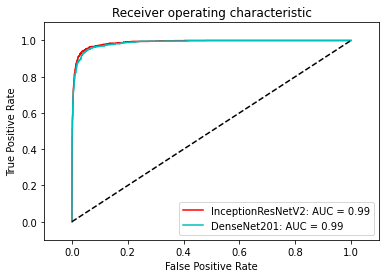

In [21]:
_auc = dict()
_auc[0] = auc(irv2_fpr, irv2_tpr)
_auc[1] = auc(den_fpr, den_tpr)

# plt.figure(figsize=(15,15))
plt.plot(irv2_fpr, irv2_tpr, 'r',label='InceptionResNetV2: AUC = %0.2f' % _auc[0])
plt.plot(den_fpr, den_tpr,'c',label='DenseNet201: AUC = %0.2f' % _auc[1])

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()